In [73]:
%matplotlib inline
# Color clustering code
# Partitions an image into potential candidate clusters

import time as time

import numpy as np
import scipy as sp

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.feature_extraction.image import grid_to_graph
from sklearn.cluster import AgglomerativeClustering
from sklearn.utils.testing import SkipTest
from sklearn.utils.fixes import sp_version

# compression of image width
ZOOM_FACTOR = 25

# min, max fraction of total image area to be considered as "good" piece
# TODO: find a better way to do this
MINP = .001
MAXP = .010

MP = .05  # min percent for the color filter

p1 = .2
p2 = .6

# maximum number of pixels in perimeter that a good image could have
MAX_PERIM = 150

# Shitty downsizing of image using ZOOM_FACTOR as stride length
# TODO: can use magick mogrify command to compress on smc for batches if we want

# input: image array and optional zoom factor z
# output: compressed image array (by factor z^2)
def comp(img,z = ZOOM_FACTOR):
#     img=mpimg.imread(impath)
    compress = img[0:len(img):z,0:len(img[0]):z]
    return compress

# converts image to greyscale by taking averages of rgb values
# returns compressed image, compressed greyscale image
def avg(img, compress = True, z = ZOOM_FACTOR):
    if compress:
        img = comp(img,z)
    w = np.zeros((len(img),len(img[0])))
    for i in range(len(img)):
        for j in range(len(img[0])):
            w[i][j] = int(img[i][j][0]/3.0+img[i][j][1]/3.0+img[i][j][2]/3.0)
    return img, w

# transforms a coordinate from compressed to full size image
def c2f(x,z = ZOOM_FACTOR):
    return int(z * x)

# checks if enough pixels are of a color contained in the set, returns true if they are
def filtr(img, s = plist, mp = MP, stride = 10): # mp minimum percentage of image in set, default 10%
    count = 0.0
    if len(img) == 0 or len(img[0]) == 0:
        return False  # image is empty
    area = len(img) * len(img[0]) * 1.0 / (stride**2)
    temp = img.reshape((-1,len(img[0][0])))
    for i in temp[0::stride]:
        # shitty way to check jpg or png
        if i[0] == int(i[0]):
            count += tuple(i) in s
        else:
            count += tuple((int(255 * i[0]),int(255 * i[1]), int(255 * i[2]))) in s
        if count / area > mp:
            return True
    return False
        
# takes in an image array and optional number of clusters desired
# returns array of size of image whose nonzero values are to which cluster each pixel belongs
def cluster(impath, n = 15, compress = True, usep = True, z = ZOOM_FACTOR, usefiltr = False): #usep will filter out small clusters
                                                                            #z zoom factor
    full_img = impath
    fig, axes = plt.subplots(1, 2, figsize=(15, 15))
    axes = axes.flatten()

    img, grey = avg(impath, compress,z)
    axes[0].imshow(img)

    # initializes connectivity matrix
    connectivity = grid_to_graph(*grey.shape)

    X = np.reshape(img, (-1, 3))
    print("Compute structured hierarchical clustering...")
    st = time.time()
    n_clusters = n  # number of regions

    # linkage basically chooses how "distance" between color values computed, ward only setting that worked for me
    ward = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward',
                                   connectivity=connectivity, compute_full_tree = 'auto')
    ward.fit(X)
    label = np.reshape(ward.labels_, grey.shape)
    print("Elapsed time: ", time.time() - st)
    print("Number of pixels: ", label.size)
    print("Number of clusters: ", np.unique(label).size)
    
    l = grey.shape[0]
    w = grey.shape[1]
    minp = label.size * MINP
    maxp = label.size * MAXP
    # counts how many pixels are in cluster l
    count = np.zeros([n_clusters,1])
    area = np.zeros((n_clusters,1))
    axes[1].imshow(img, cmap=plt.cm.gray)
    
    # list of image (candidates) to be returned
    # nth element is cropped image of nth cluster
    img_list = []

    # tool to find dimensions of each img in array to be returned
    # elements are farthest up, down, left, right each cluster has
    dims = np.zeros([n_clusters,4])
    for i in range(len(dims)):
        dims[i][0] = l
        dims[i][2] = w

    # count perimeter of each cluster
    # doesn't count last row/column but that should be okay?
    for i in range(1,np.shape(label)[0]-1):
        for j in range(1,np.shape(label)[1]-1):
            l = label[i,j]
            area[label[i,j]] += 1
            # TODO: double check this logic
            cl = label[i,j]
            if (cl != label[i,j+1] or cl != label[i, j-1]) or (cl != label[i+1,j] or cl != label[i-1,j]):
                count[label[i,j]] += 1
            # update dim
            if dims[l][0] > i:
                dims[l][0] = i
            if dims[l][1] < i:
                dims[l][1] = i
            if dims[l][2] > j:
                dims[l][2] = j
            if dims[l][3] < j:
                dims[l][3] = j

    for l in range(n_clusters):
        z = ZOOM_FACTOR
        perim = count[l]
        ar = area[l]
        if (not usep or (perim < MAX_PERIM and area[l] > minp and area[l] < maxp)):
            if filtr(full_img[c2f(dims[l][0],z)-z:c2f(dims[l][1],z)+z,c2f(dims[l][2],z)-z:c2f(dims[l][3],z)+z], plist, p1):
                plt.contour(label == l, contours=1,
                colors=[plt.cm.spectral(l / float(n_clusters)), ])
                # the +- z parts pad image to avoid overcropping
                img_list.append(full_img[c2f(dims[l][0],z)-z:c2f(dims[l][1],z)+z,c2f(dims[l][2],z)-z:c2f(dims[l][3],z)+z])
    #             print(dims[l][0])
    plt.show()
    return img_list

# clustering to be performed on partitioned image (seperates background from image)
def cluster2(img,n=2, compress=True, usep = False, zoom = 10):
    a = cluster(img,n, compress,usep, zoom, usefiltr = True)
    for b in a:
        print(filtr(b, plist, p2))
        if filtr(b, plist, p2):
            plt.imshow(b)
            plt.show()

Compute structured hierarchical clustering...
Elapsed time:  2.588841676712036
Number of pixels:  28912
Number of clusters:  200


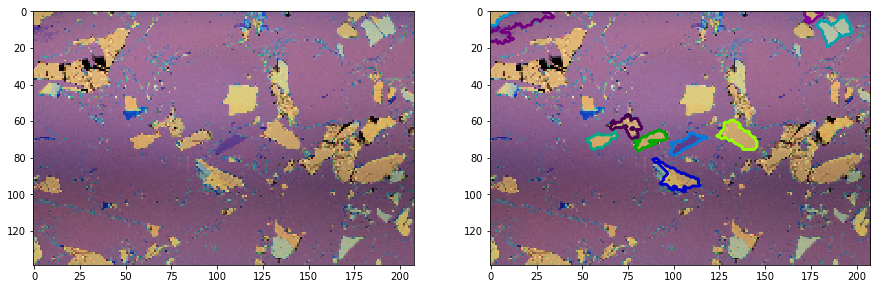

Compute structured hierarchical clustering...
Elapsed time:  0.15612387657165527
Number of pixels:  1575
Number of clusters:  2


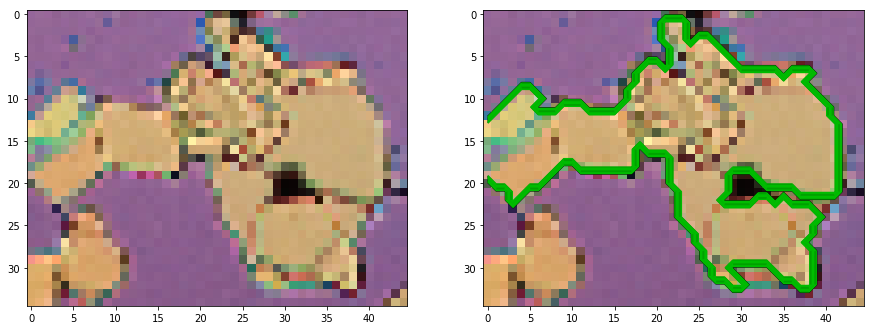

False
False
Compute structured hierarchical clustering...
Elapsed time:  0.24218249320983887
Number of pixels:  3960
Number of clusters:  2


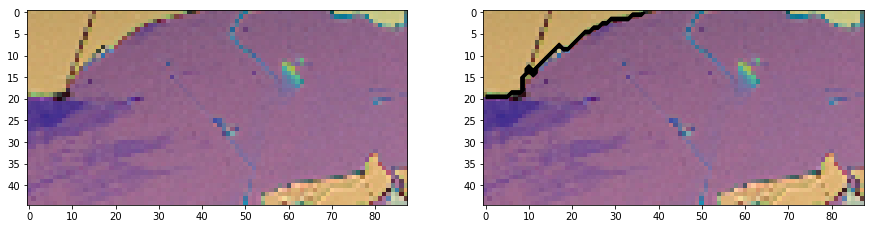

False
Compute structured hierarchical clustering...
Elapsed time:  0.026018381118774414
Number of pixels:  504
Number of clusters:  2


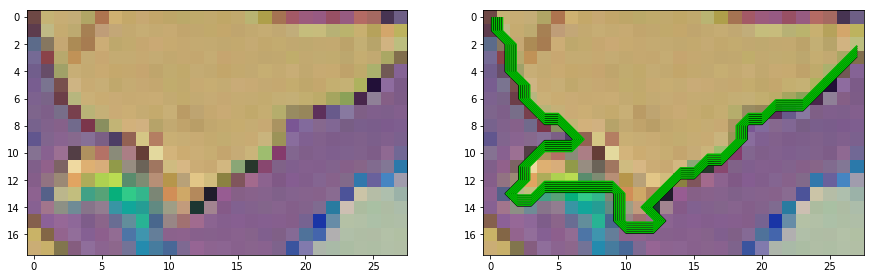

False
False
Compute structured hierarchical clustering...
Elapsed time:  0.24518966674804688
Number of pixels:  3264
Number of clusters:  2


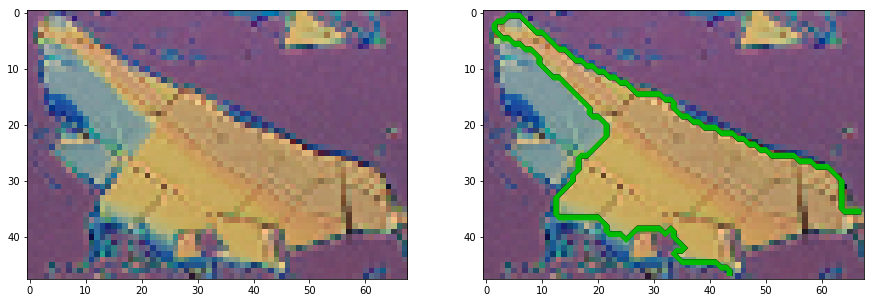

False
False
Compute structured hierarchical clustering...
Elapsed time:  0.09806990623474121
Number of pixels:  1749
Number of clusters:  2


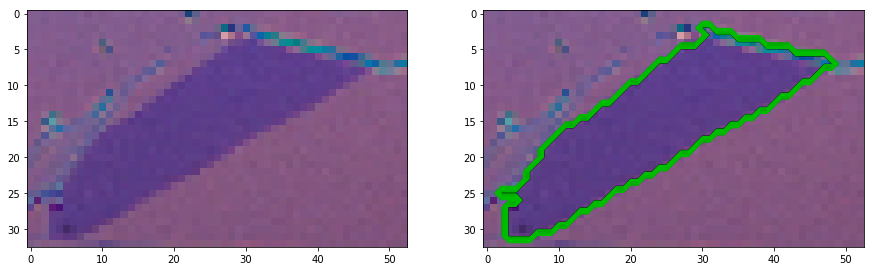

True


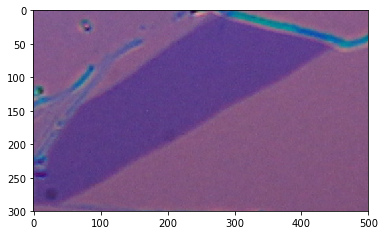

True


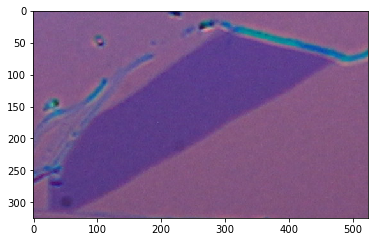

Compute structured hierarchical clustering...
Elapsed time:  0.02800750732421875
Number of pixels:  560
Number of clusters:  2


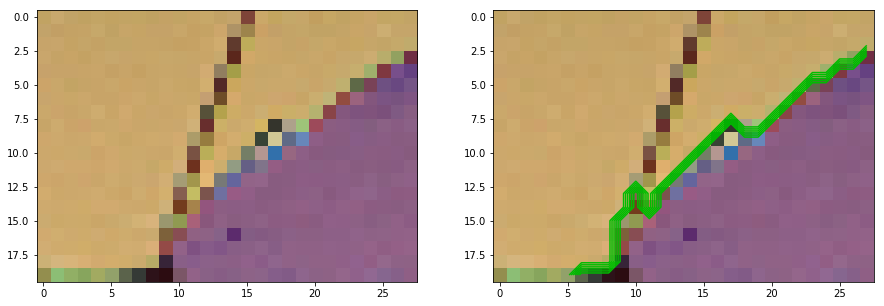

False
Compute structured hierarchical clustering...
Elapsed time:  0.1791391372680664
Number of pixels:  2400
Number of clusters:  2


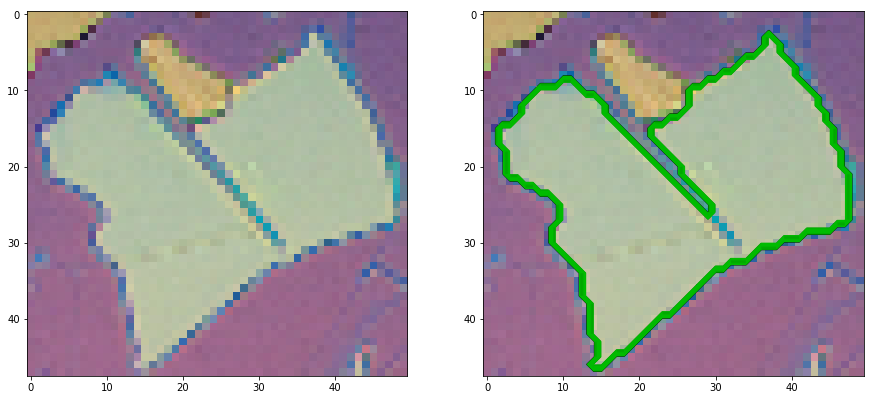

False
False
Compute structured hierarchical clustering...
Elapsed time:  0.09206557273864746
Number of pixels:  1260
Number of clusters:  2


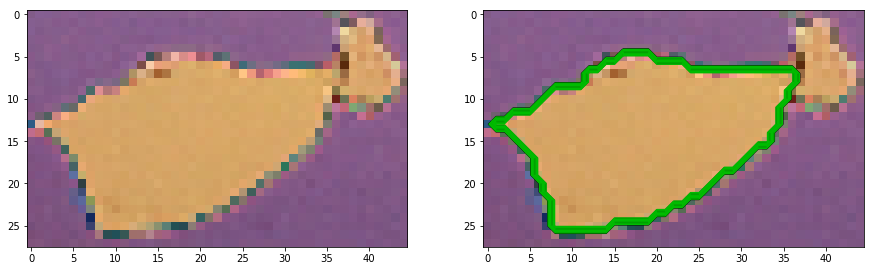

True


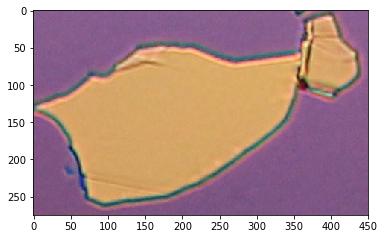

True


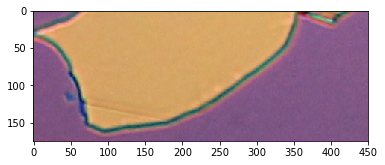

Compute structured hierarchical clustering...
Elapsed time:  0.09406685829162598
Number of pixels:  1584
Number of clusters:  2


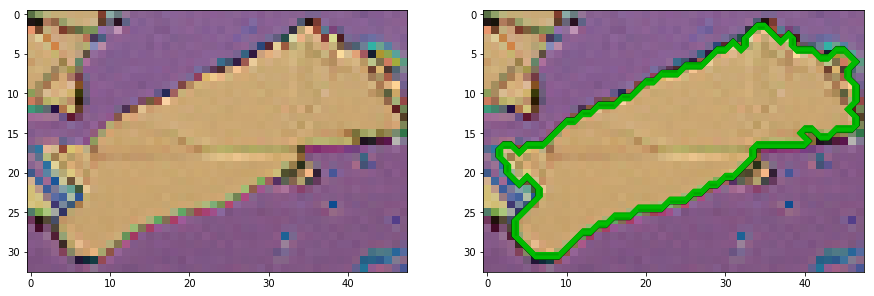

True


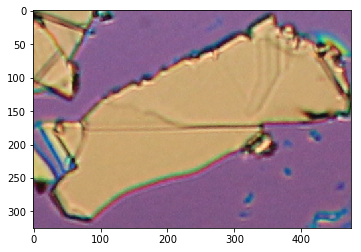

True


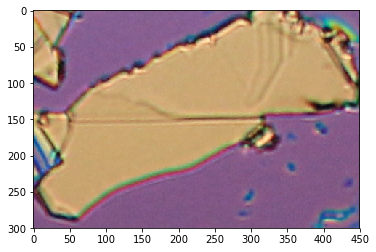

Compute structured hierarchical clustering...
Elapsed time:  0.1611194610595703
Number of pixels:  2494
Number of clusters:  2


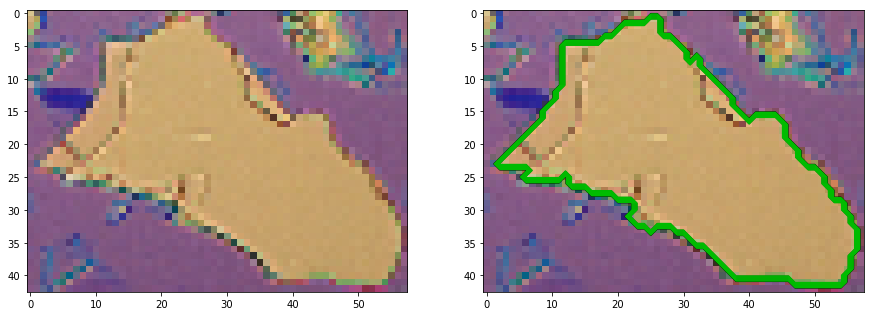

False
False
Compute structured hierarchical clustering...
Elapsed time:  3.979698657989502
Number of pixels:  28912
Number of clusters:  200


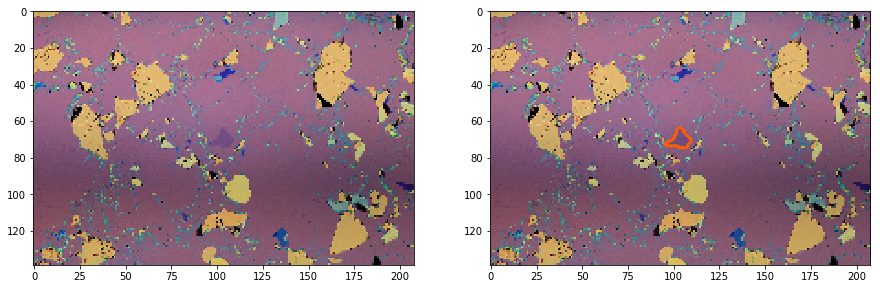

Compute structured hierarchical clustering...
Elapsed time:  0.13809895515441895
Number of pixels:  1140
Number of clusters:  2


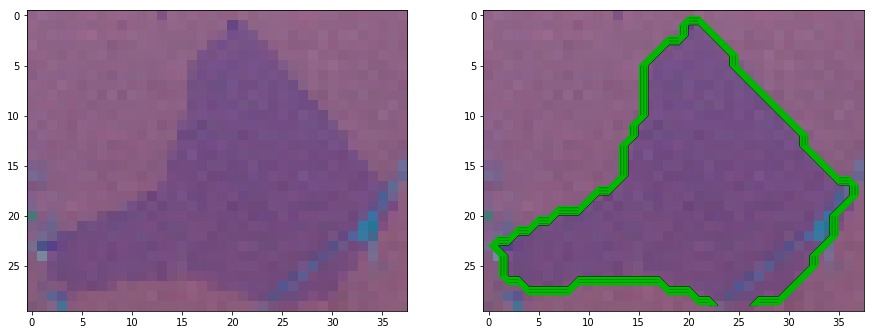

True


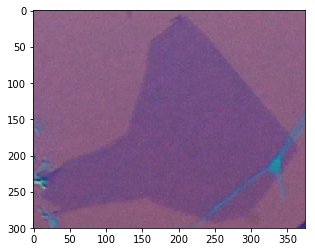

True


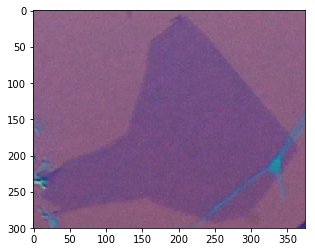

Compute structured hierarchical clustering...
Elapsed time:  5.404845952987671
Number of pixels:  28912
Number of clusters:  200


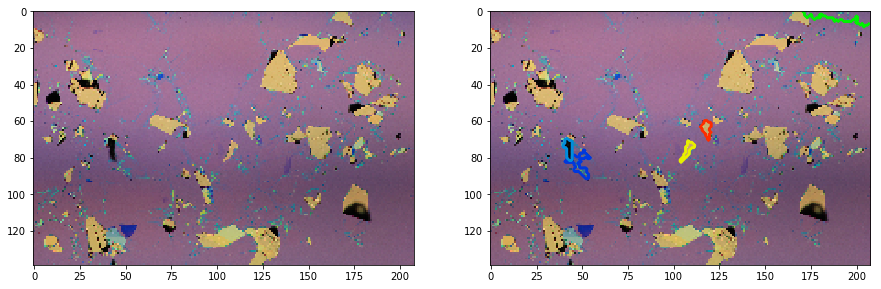

Compute structured hierarchical clustering...
Elapsed time:  0.3702504634857178
Number of pixels:  1634
Number of clusters:  2


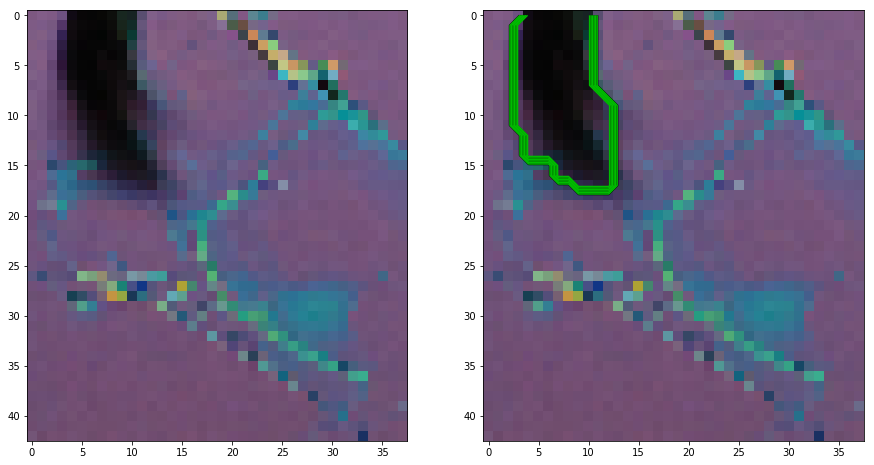

False
False
Compute structured hierarchical clustering...
Elapsed time:  0.06005549430847168
Number of pixels:  495
Number of clusters:  2


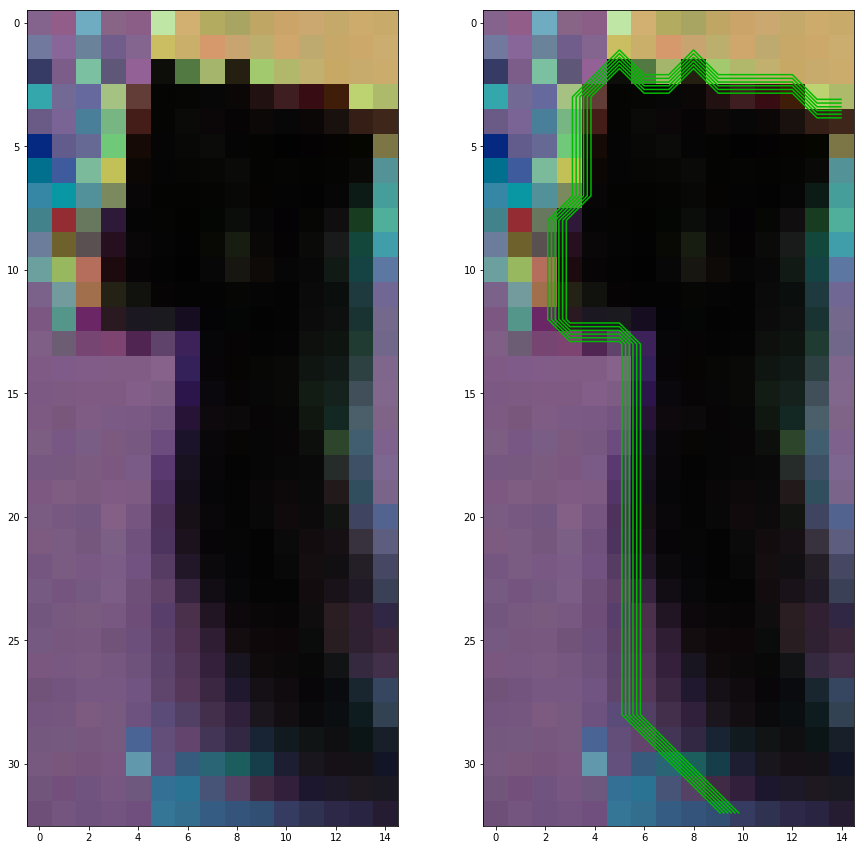

False
Compute structured hierarchical clustering...
Elapsed time:  0.11908888816833496
Number of pixels:  2070
Number of clusters:  2


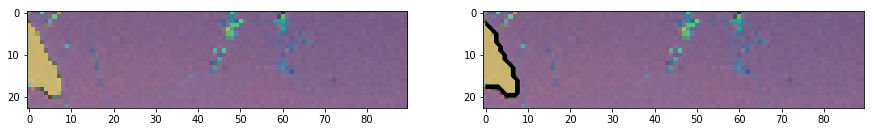

False
Compute structured hierarchical clustering...
Elapsed time:  0.04503059387207031
Number of pixels:  759
Number of clusters:  2


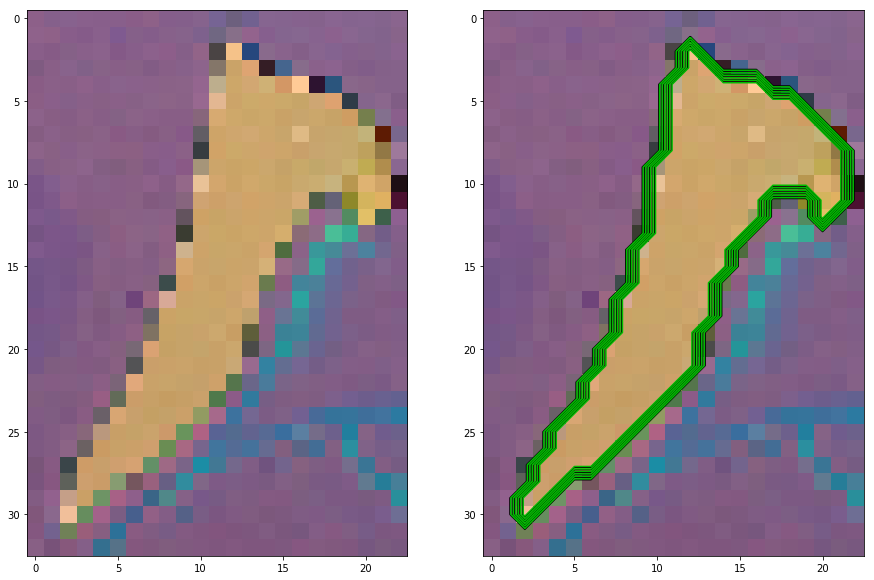

True


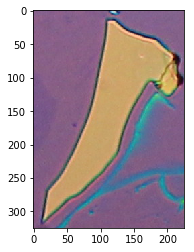

False
Compute structured hierarchical clustering...
Elapsed time:  0.03502249717712402
Number of pixels:  540
Number of clusters:  2


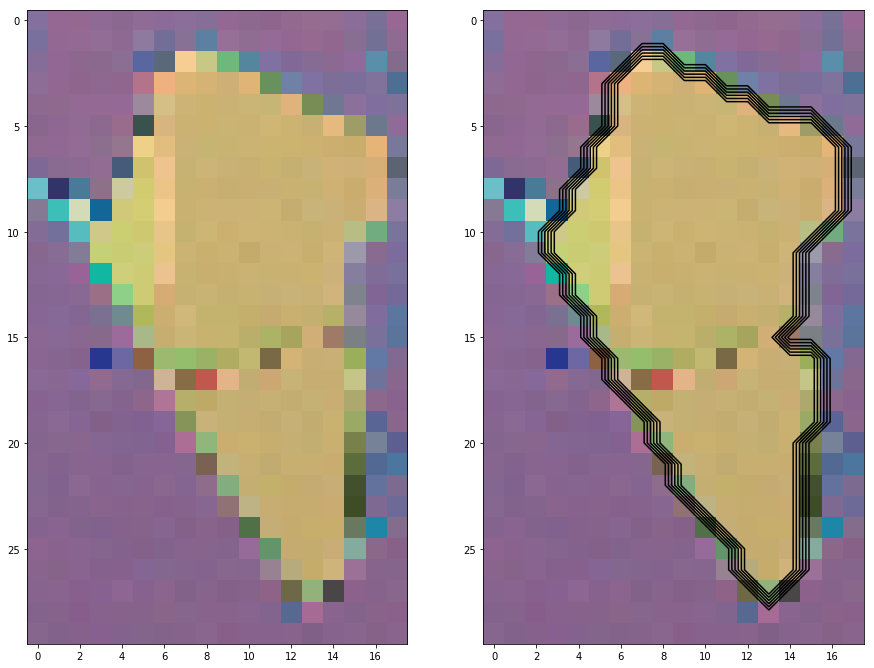

False
Compute structured hierarchical clustering...
Elapsed time:  2.9701120853424072
Number of pixels:  28912
Number of clusters:  200


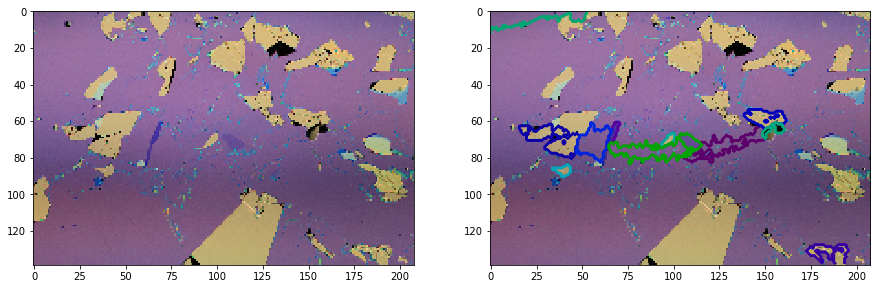

Compute structured hierarchical clustering...
Elapsed time:  0.5954384803771973
Number of pixels:  5989
Number of clusters:  2


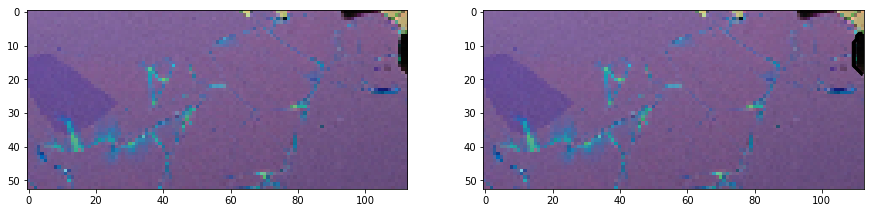

True


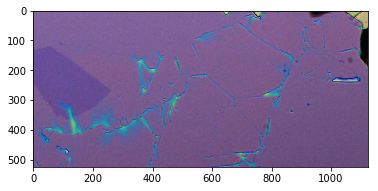

Compute structured hierarchical clustering...
Elapsed time:  0.047034263610839844
Number of pixels:  800
Number of clusters:  2


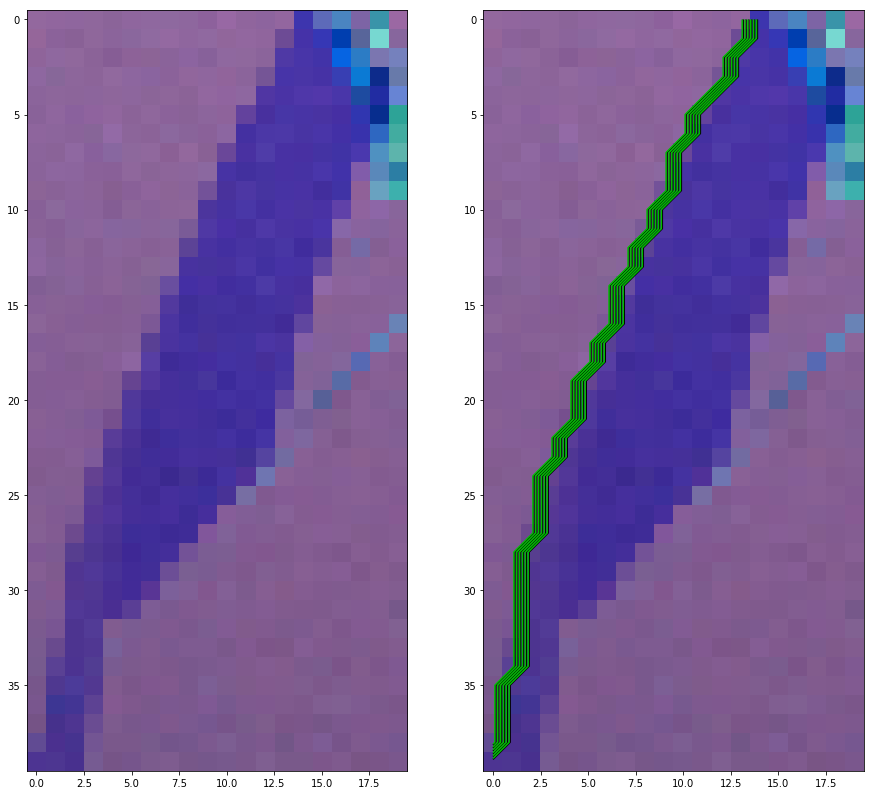

True


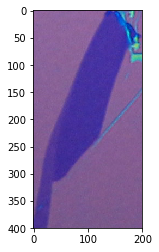

True


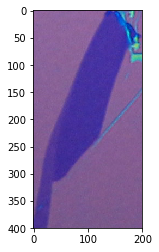

Compute structured hierarchical clustering...
Elapsed time:  0.11407995223999023
Number of pixels:  1680
Number of clusters:  2


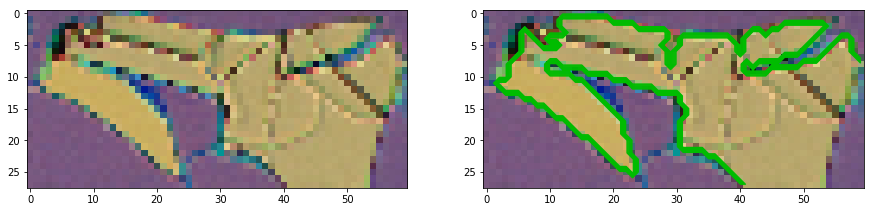

False
Compute structured hierarchical clustering...
Elapsed time:  0.2952077388763428
Number of pixels:  4250
Number of clusters:  2


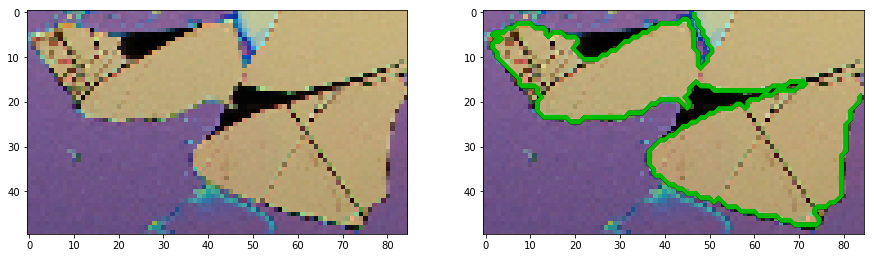

True


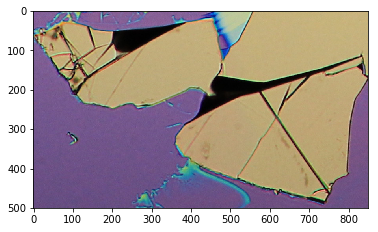

True


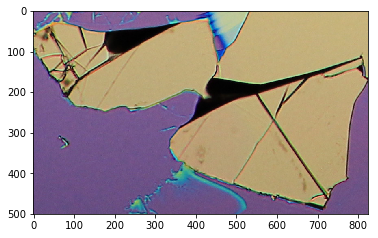

Compute structured hierarchical clustering...
Elapsed time:  0.12610363960266113
Number of pixels:  1800
Number of clusters:  2


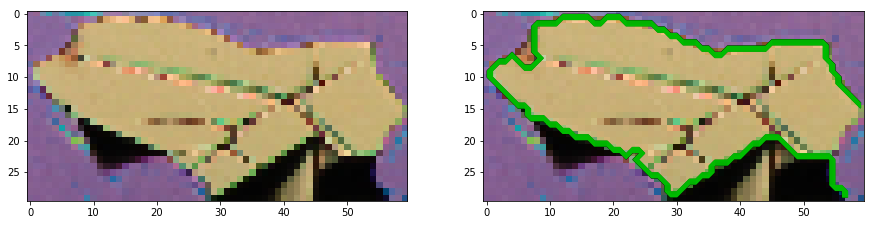

False
False
Compute structured hierarchical clustering...
Elapsed time:  0.17912817001342773
Number of pixels:  3074
Number of clusters:  2


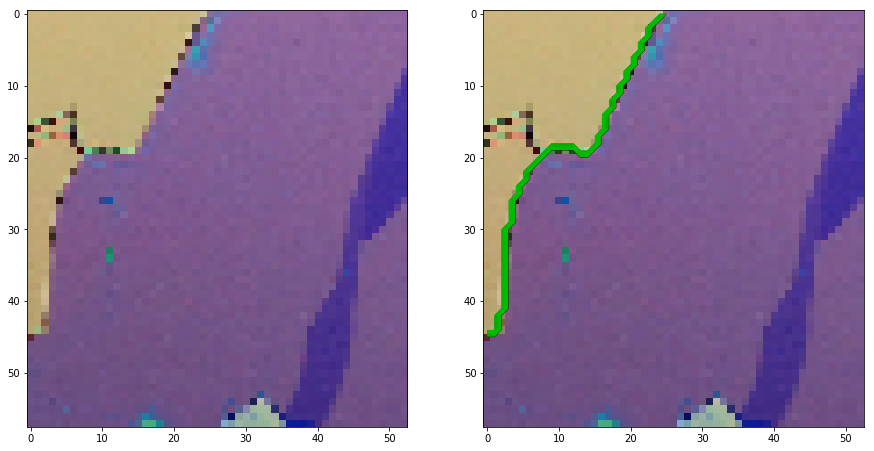

True


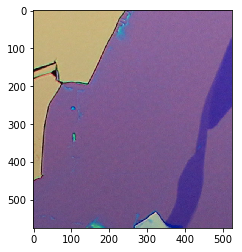

True


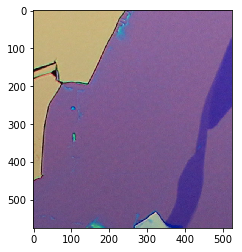

Compute structured hierarchical clustering...
Elapsed time:  0.030025959014892578
Number of pixels:  560
Number of clusters:  2


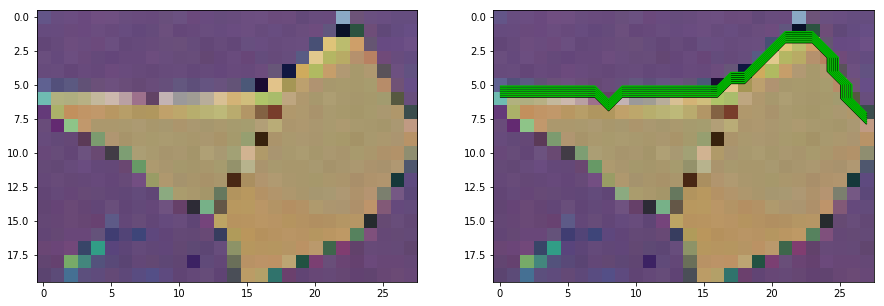

True


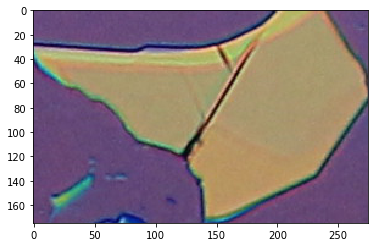

True


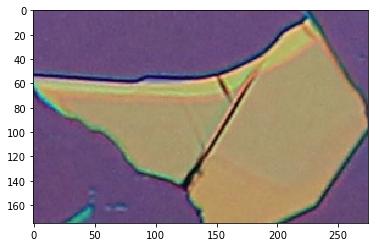

Compute structured hierarchical clustering...
Elapsed time:  0.0310211181640625
Number of pixels:  529
Number of clusters:  2


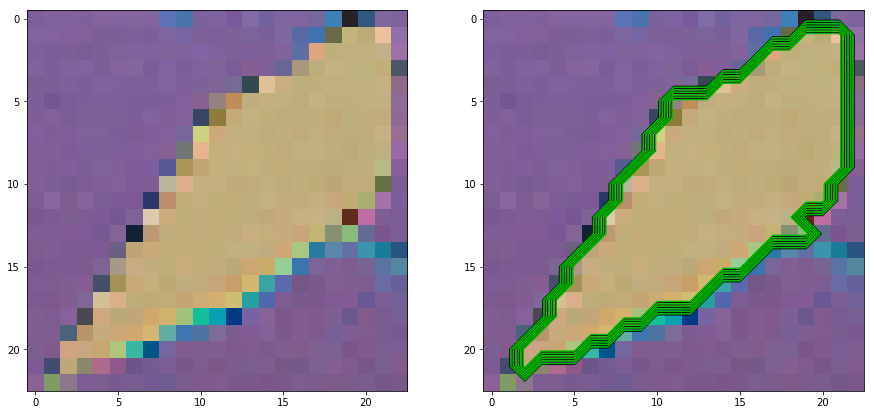

True


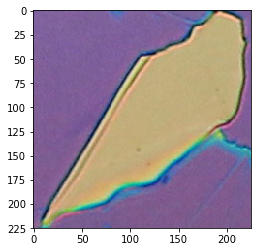

True


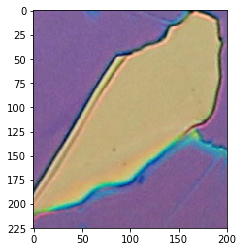

Compute structured hierarchical clustering...
Elapsed time:  0.04703235626220703
Number of pixels:  825
Number of clusters:  2


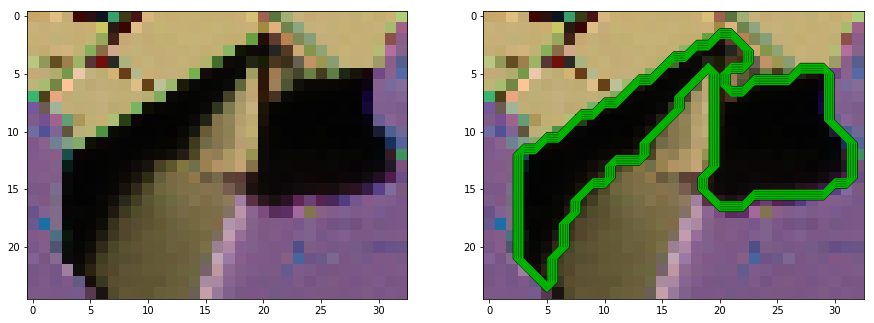

True


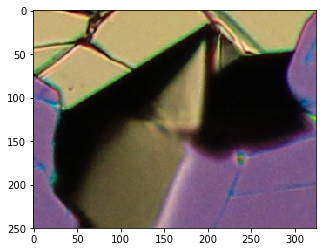

True


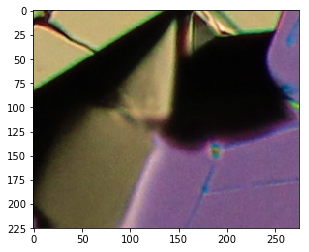

Compute structured hierarchical clustering...
Elapsed time:  0.2321767807006836
Number of pixels:  3724
Number of clusters:  2


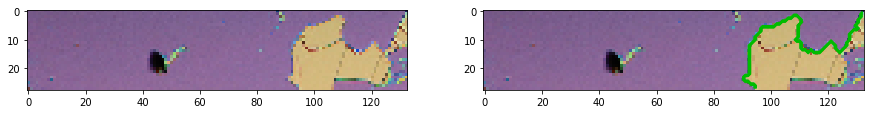

True


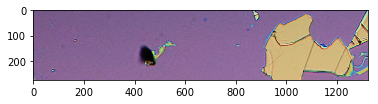

Compute structured hierarchical clustering...
Elapsed time:  0.30121302604675293
Number of pixels:  4400
Number of clusters:  2


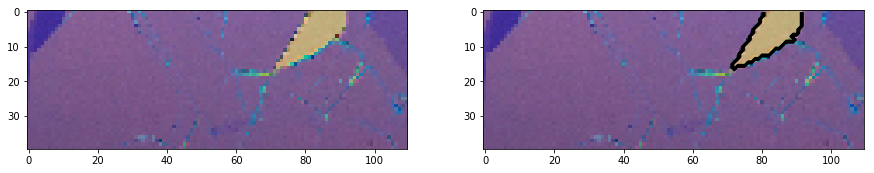

True


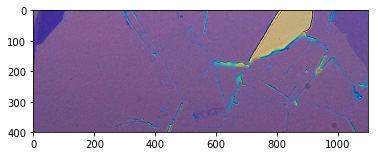

Compute structured hierarchical clustering...
Elapsed time:  0.08307147026062012
Number of pixels:  1225
Number of clusters:  2


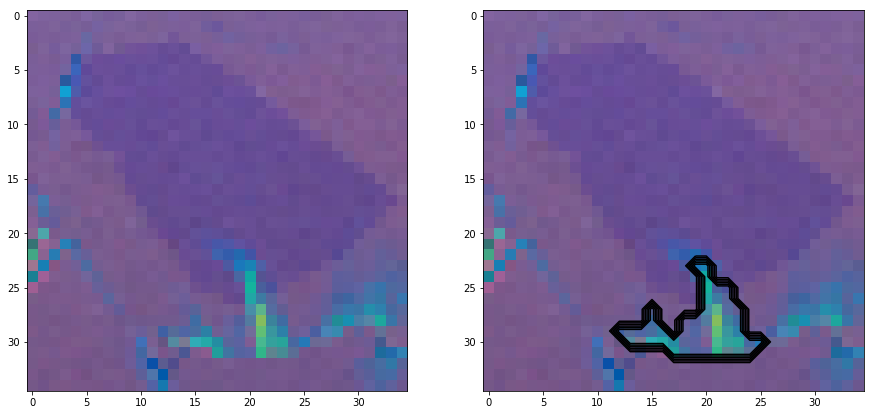

True


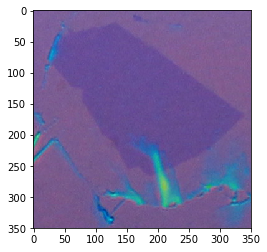

Compute structured hierarchical clustering...
Elapsed time:  2.8750319480895996
Number of pixels:  28912
Number of clusters:  200


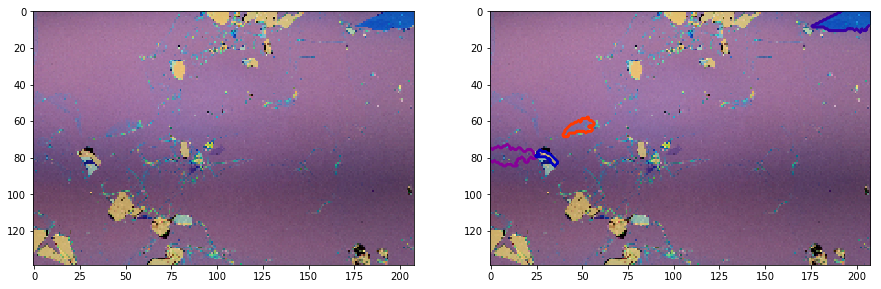

Compute structured hierarchical clustering...
Elapsed time:  0.15711188316345215
Number of pixels:  2079
Number of clusters:  2


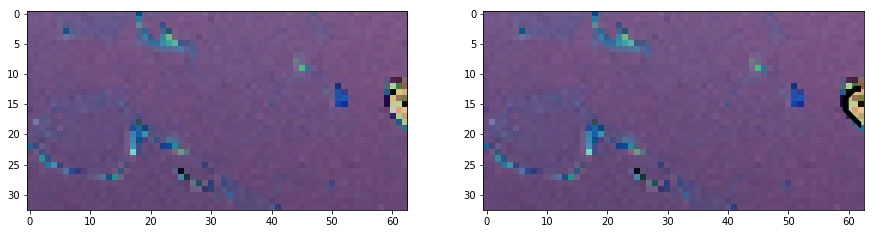

True


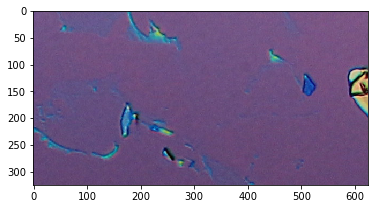

Compute structured hierarchical clustering...
Elapsed time:  0.1651167869567871
Number of pixels:  2400
Number of clusters:  2


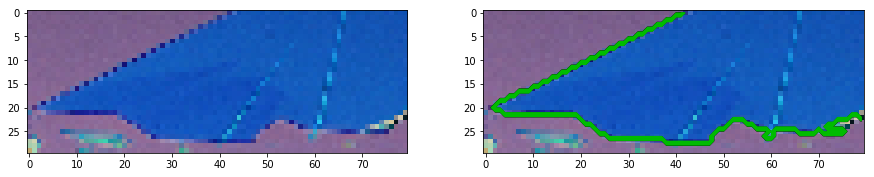

False
False
Compute structured hierarchical clustering...
Elapsed time:  0.04805111885070801
Number of pixels:  825
Number of clusters:  2


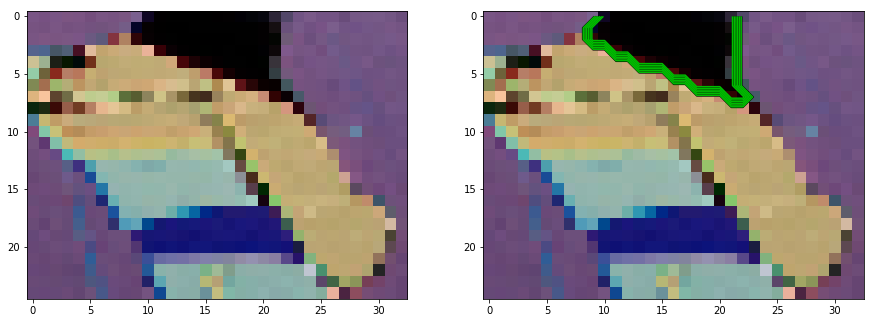

True


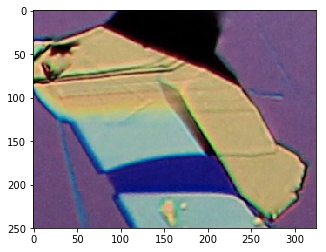

True


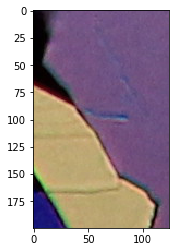

Compute structured hierarchical clustering...
Elapsed time:  0.08005666732788086
Number of pixels:  1350
Number of clusters:  2


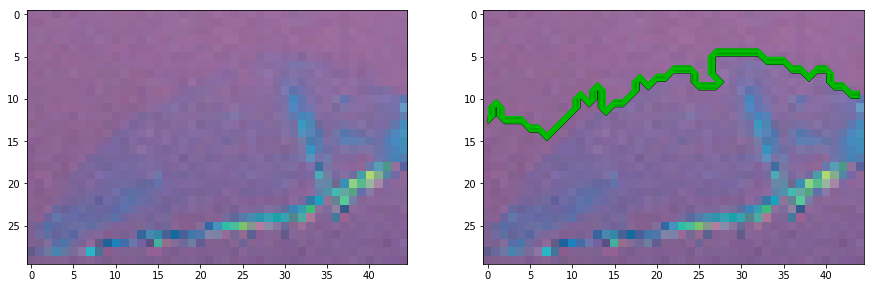

True


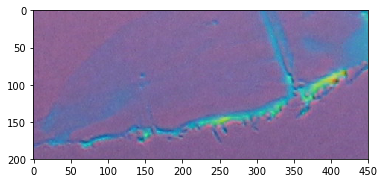

False
Compute structured hierarchical clustering...
Elapsed time:  2.548797369003296
Number of pixels:  28912
Number of clusters:  200


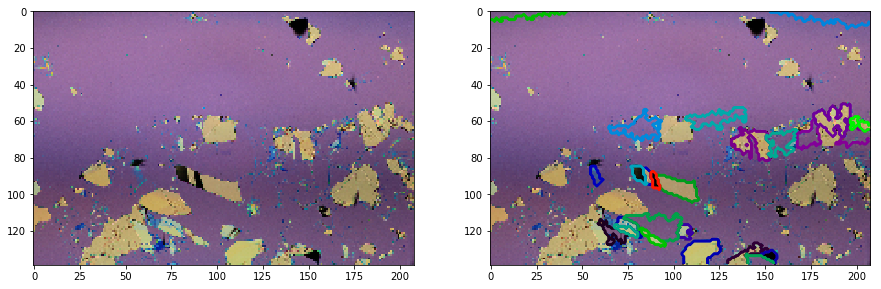

Compute structured hierarchical clustering...
Elapsed time:  0.10807442665100098
Number of pixels:  1710
Number of clusters:  2


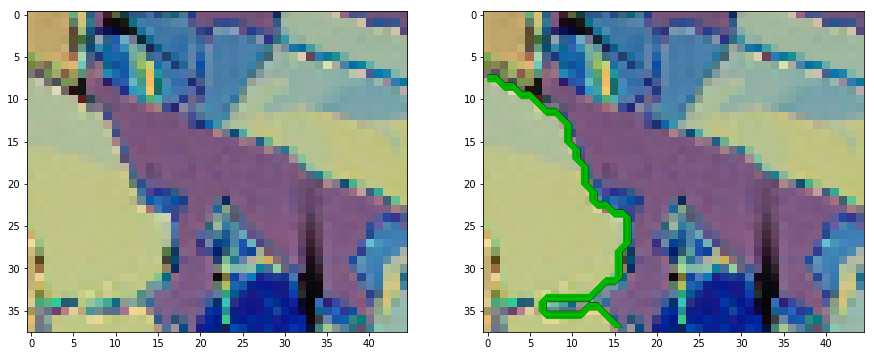

False
False
Compute structured hierarchical clustering...
Elapsed time:  0.11406850814819336
Number of pixels:  1740
Number of clusters:  2


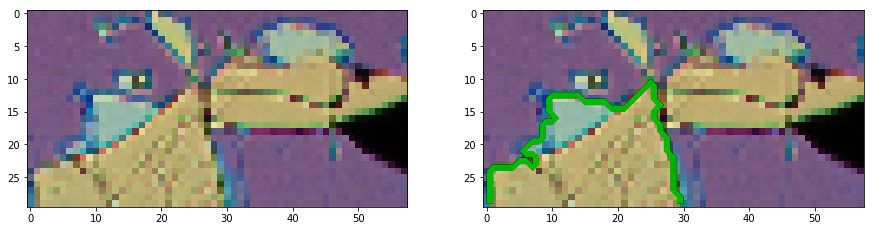

True


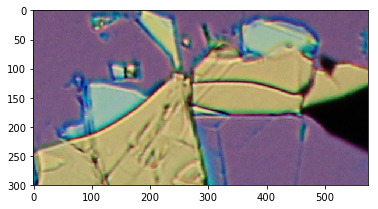

True


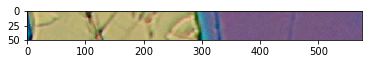

Compute structured hierarchical clustering...
Elapsed time:  0.3142106533050537
Number of pixels:  2784
Number of clusters:  2


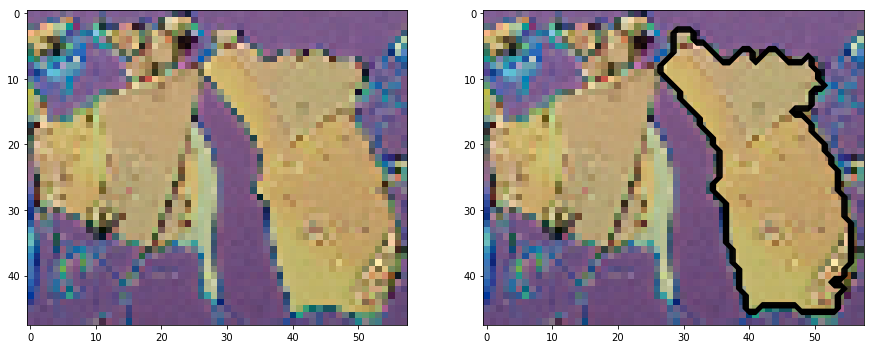

True


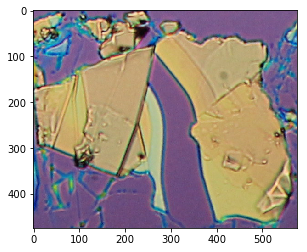

Compute structured hierarchical clustering...
Elapsed time:  0.10606122016906738
Number of pixels:  1680
Number of clusters:  2


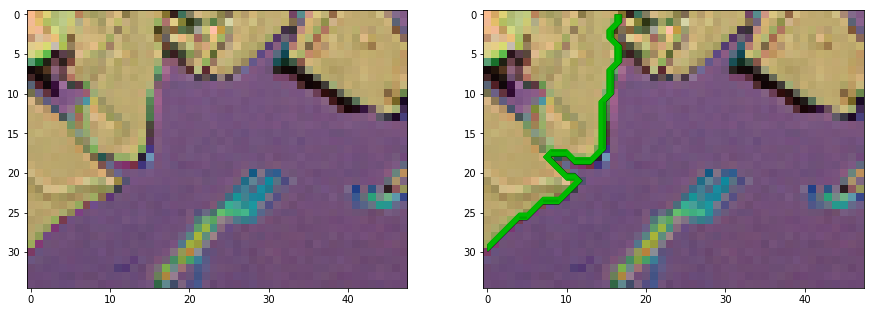

True


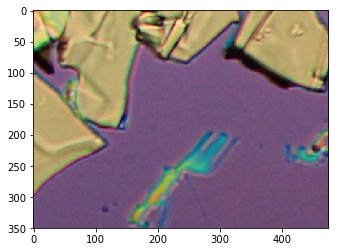

True


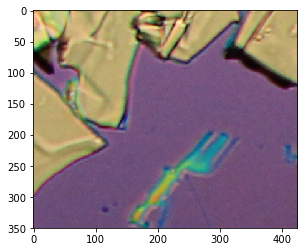

Compute structured hierarchical clustering...
Elapsed time:  0.09006500244140625
Number of pixels:  1575
Number of clusters:  2


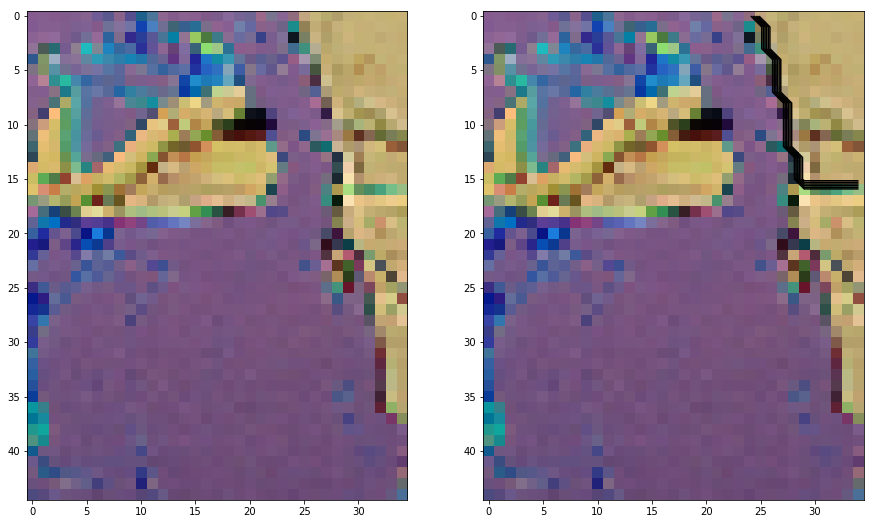

True


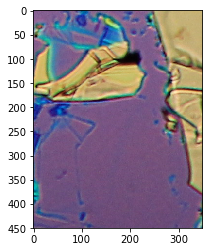

Compute structured hierarchical clustering...
Elapsed time:  0.15512371063232422
Number of pixels:  2544
Number of clusters:  2


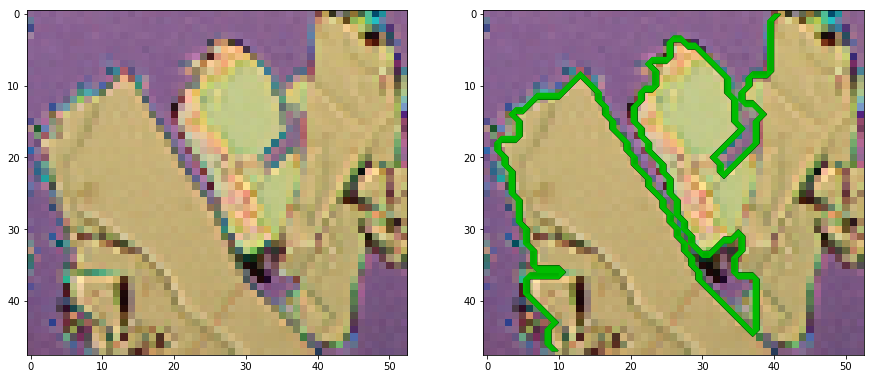

False
False
Compute structured hierarchical clustering...
Elapsed time:  0.08207011222839355
Number of pixels:  575
Number of clusters:  2


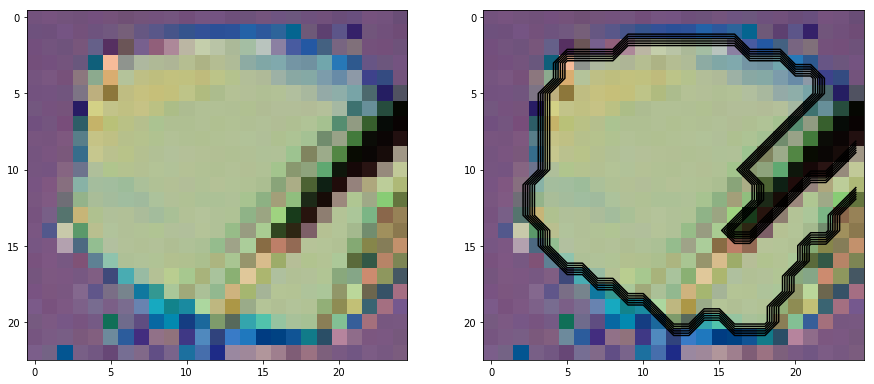

False
Compute structured hierarchical clustering...
Elapsed time:  0.02801990509033203
Number of pixels:  500
Number of clusters:  2


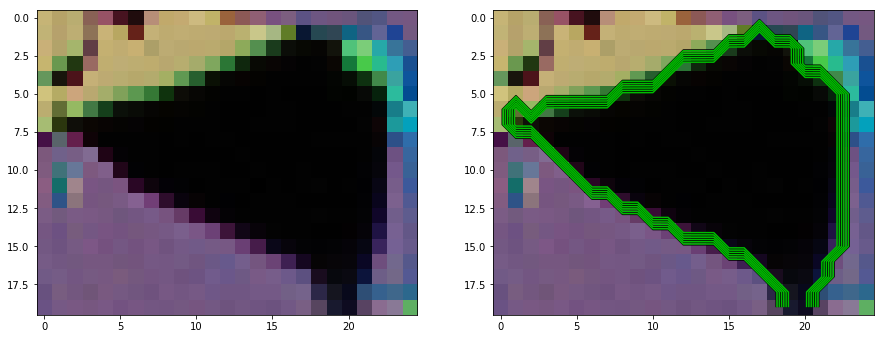

True


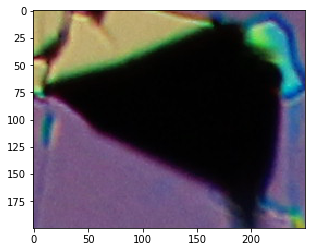

True


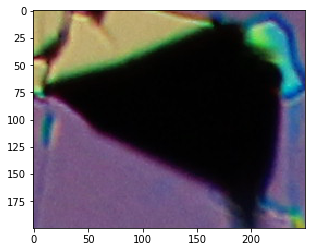

Compute structured hierarchical clustering...
Elapsed time:  0.07105016708374023
Number of pixels:  1140
Number of clusters:  2


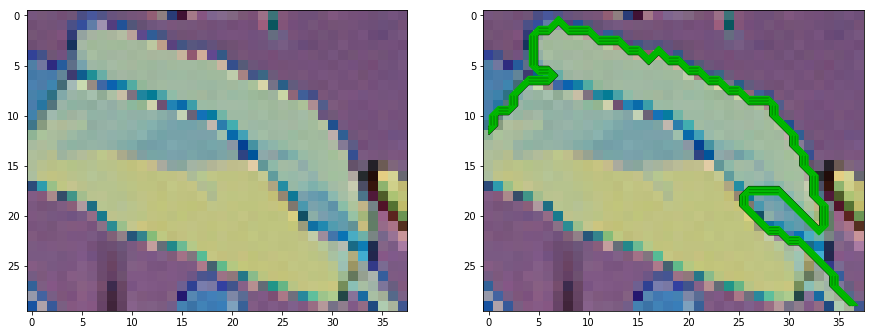

False
False
Compute structured hierarchical clustering...
Elapsed time:  0.16912007331848145
Number of pixels:  1925
Number of clusters:  2


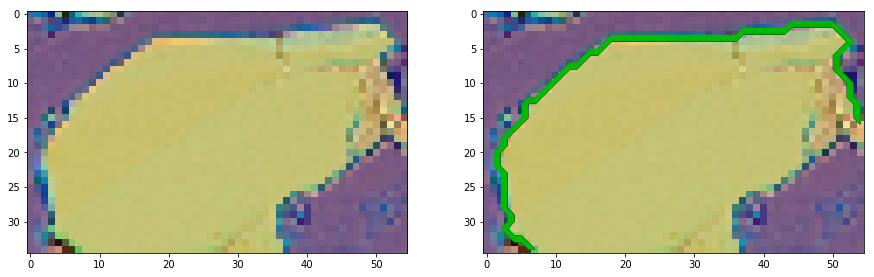

False
False
Compute structured hierarchical clustering...
Elapsed time:  0.03504014015197754
Number of pixels:  600
Number of clusters:  2


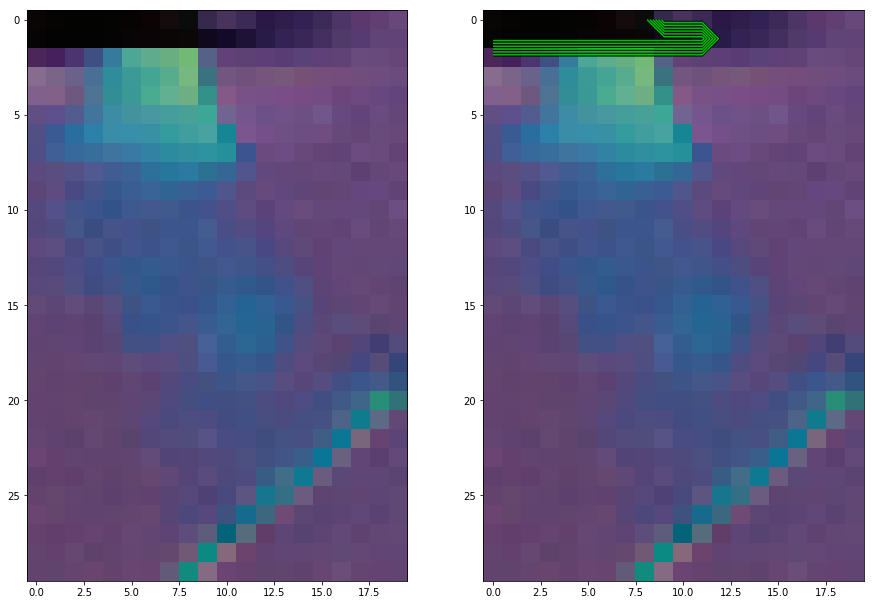

False
True


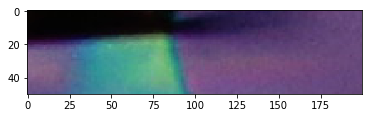

Compute structured hierarchical clustering...
Elapsed time:  0.01901841163635254
Number of pixels:  375
Number of clusters:  2


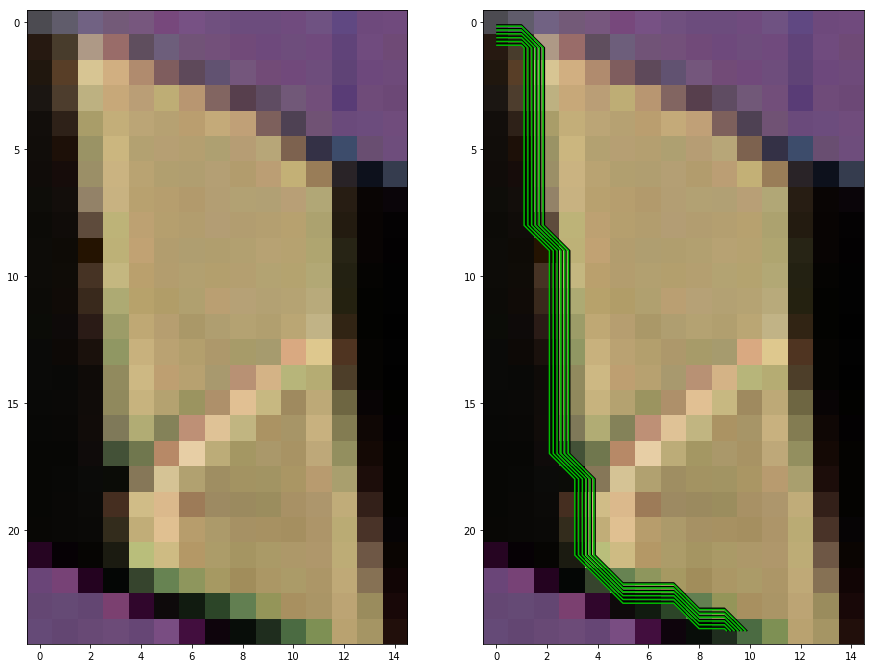

True


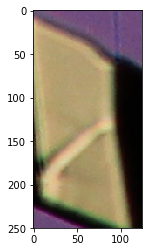

True


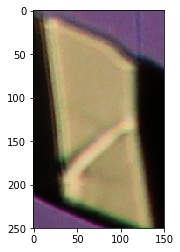

Compute structured hierarchical clustering...
Elapsed time:  0.2802128791809082
Number of pixels:  3125
Number of clusters:  2


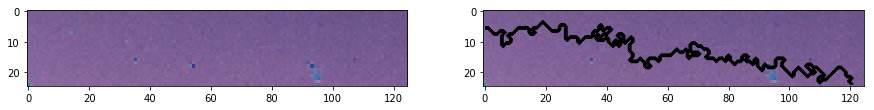

False
Compute structured hierarchical clustering...
Elapsed time:  0.2111365795135498
Number of pixels:  3375
Number of clusters:  2


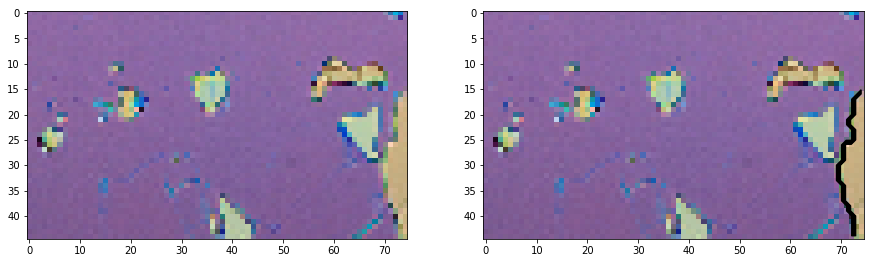

False
Compute structured hierarchical clustering...
Elapsed time:  0.03802680969238281
Number of pixels:  700
Number of clusters:  2


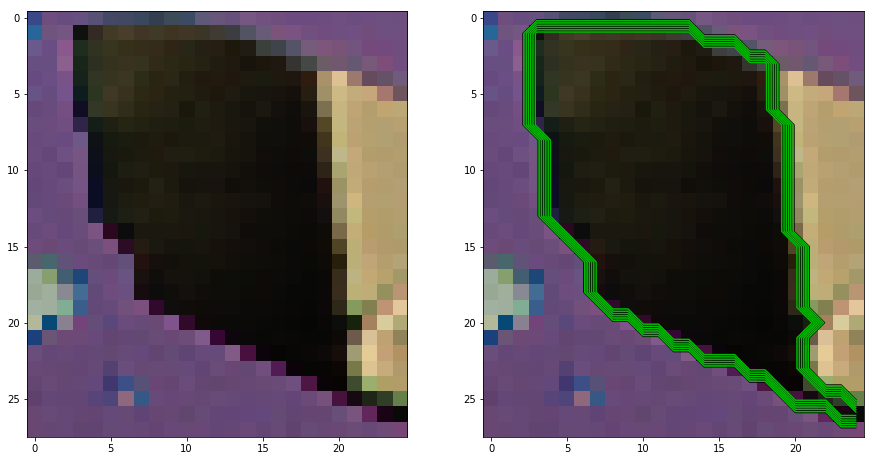

True


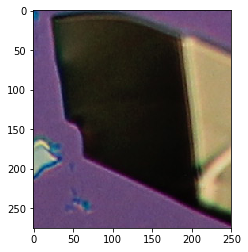

True


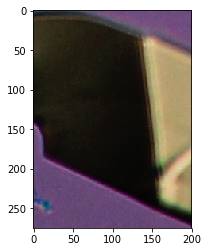

Compute structured hierarchical clustering...
Elapsed time:  0.16011309623718262
Number of pixels:  2805
Number of clusters:  2


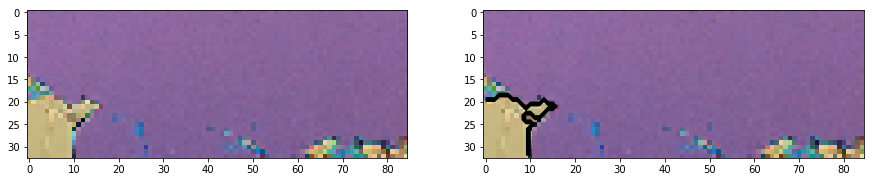

False
Compute structured hierarchical clustering...
Elapsed time:  0.1150810718536377
Number of pixels:  1800
Number of clusters:  2


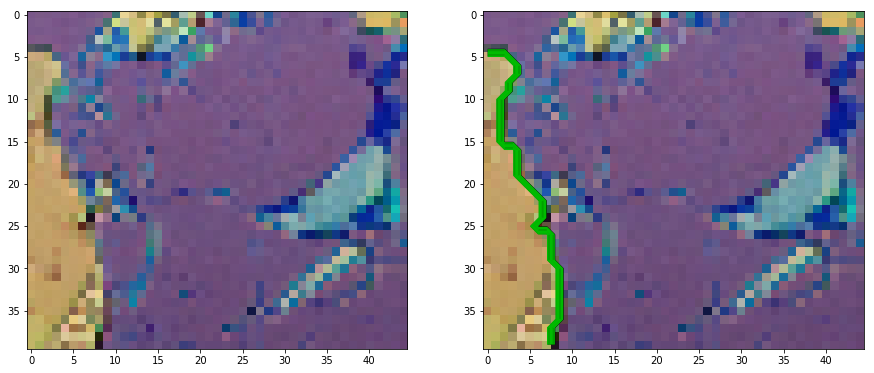

True


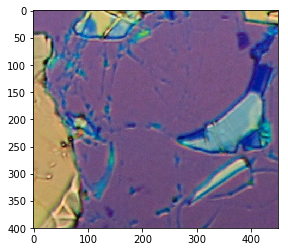

True


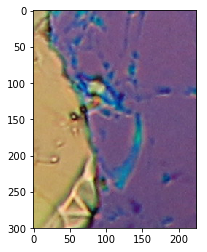

Compute structured hierarchical clustering...
Elapsed time:  0.03902935981750488
Number of pixels:  700
Number of clusters:  2


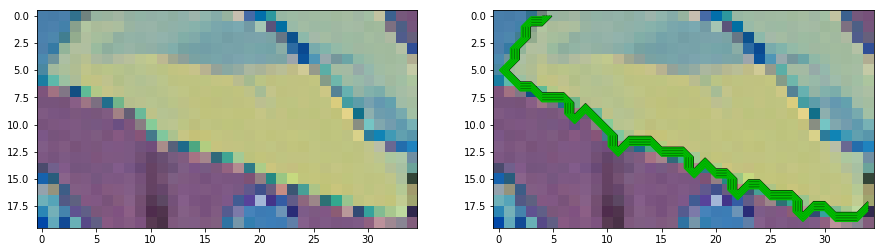

False
False
Compute structured hierarchical clustering...
Elapsed time:  0.05403780937194824
Number of pixels:  600
Number of clusters:  2


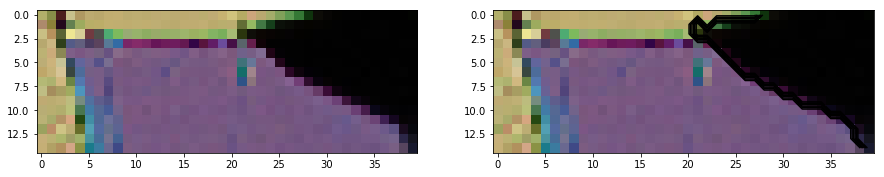

True


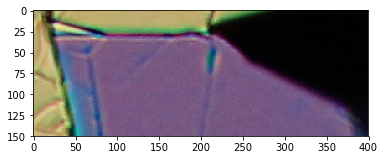

Compute structured hierarchical clustering...
Elapsed time:  0.3672466278076172
Number of pixels:  3320
Number of clusters:  2


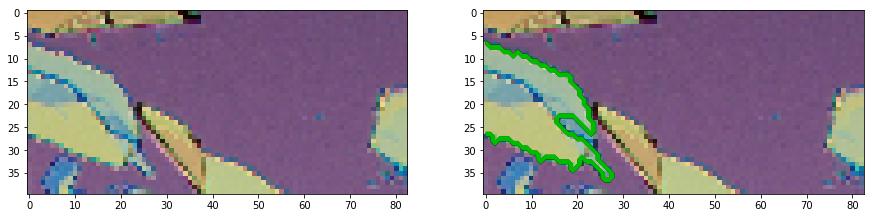

True


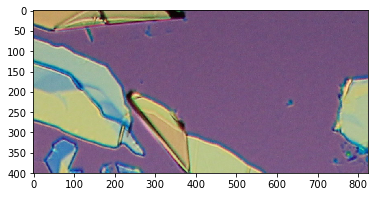

True


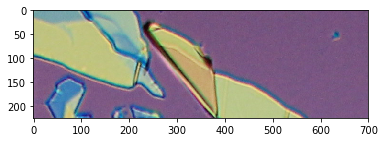

Compute structured hierarchical clustering...
Elapsed time:  0.1531081199645996
Number of pixels:  2400
Number of clusters:  2


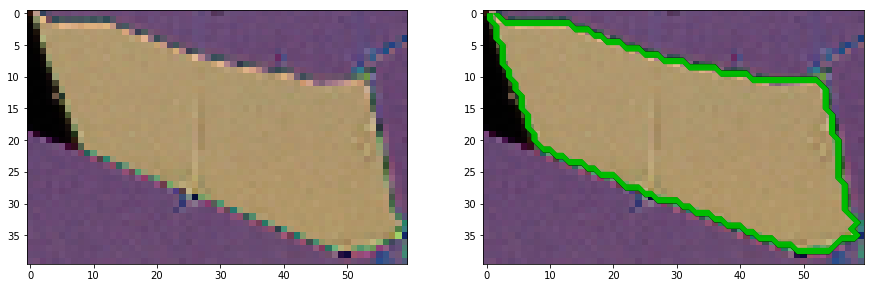

False
False
Compute structured hierarchical clustering...
Elapsed time:  0.08606266975402832
Number of pixels:  1545
Number of clusters:  2


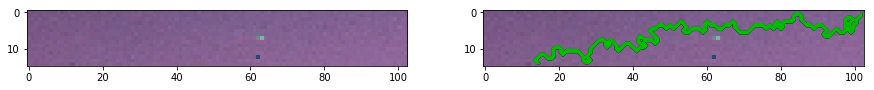

True


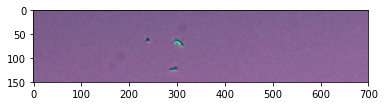

True


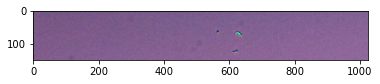

Compute structured hierarchical clustering...
Elapsed time:  0.062044382095336914
Number of pixels:  1064
Number of clusters:  2


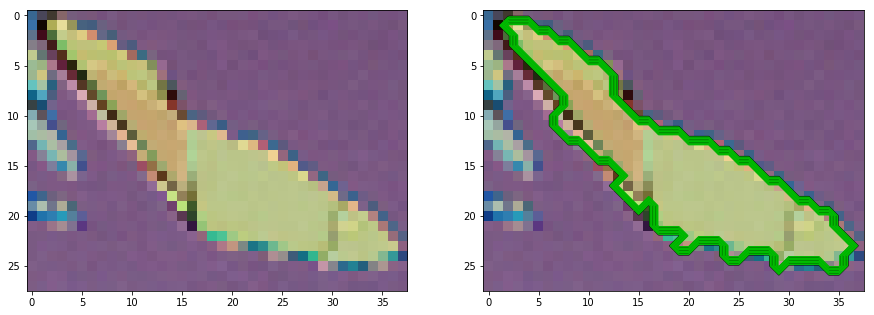

True


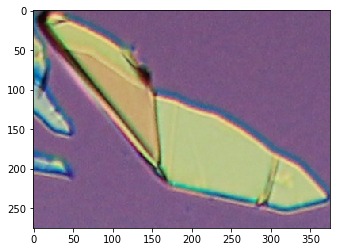

True


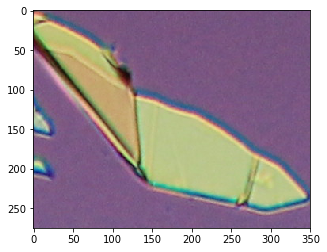

Compute structured hierarchical clustering...
Elapsed time:  0.03803110122680664
Number of pixels:  644
Number of clusters:  2


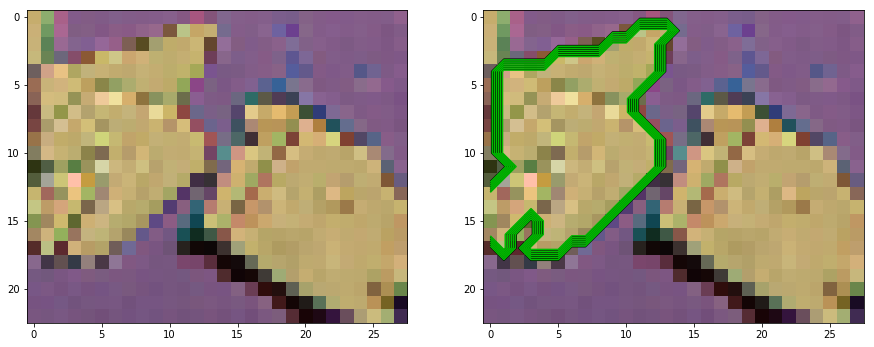

True


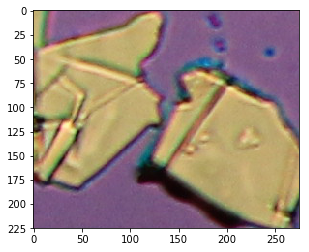

True


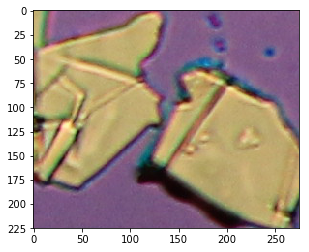

Compute structured hierarchical clustering...
Elapsed time:  0.023015975952148438
Number of pixels:  420
Number of clusters:  2


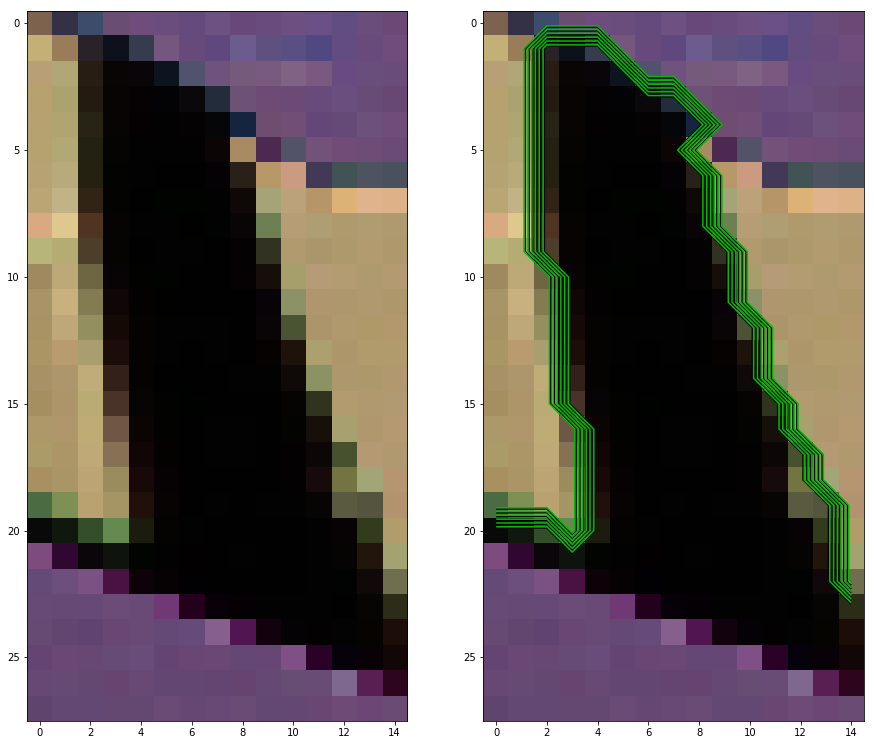

False
False
Compute structured hierarchical clustering...
Elapsed time:  2.4327430725097656
Number of pixels:  28912
Number of clusters:  200


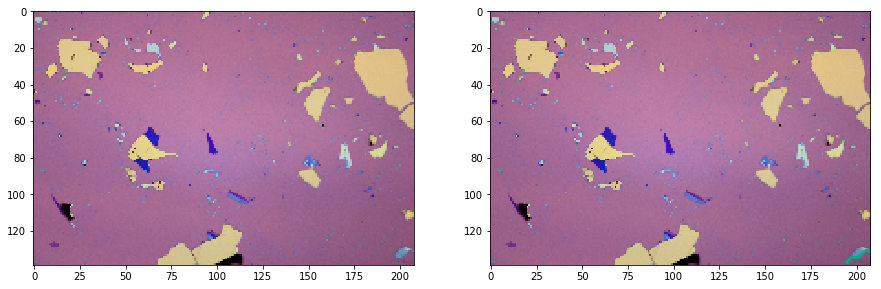

Compute structured hierarchical clustering...
Elapsed time:  0.04102945327758789
Number of pixels:  660
Number of clusters:  2


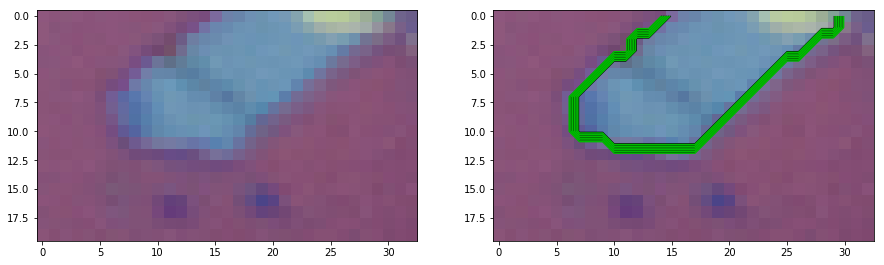

False
False
Compute structured hierarchical clustering...
Elapsed time:  2.518791437149048
Number of pixels:  28912
Number of clusters:  200


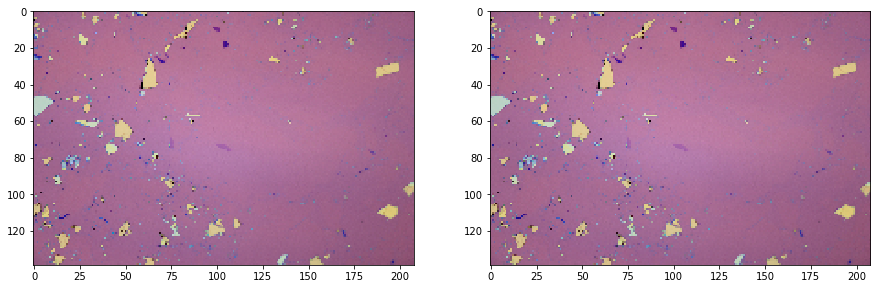

In [74]:
from os import listdir
from os.path import isfile, join
mypath = 'C:\\Users\\Andy\\Pictures\\good_imgs\\'
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]


for f in onlyfiles:
    k = cluster(mpimg.imread(mypath + f), 200)
    for l in k:
        cluster2(l,2, True)

In [ ]:
# build list of "good" graphene rgb values
# Cropped is a folder containing cropped photos of graphene, located in GoodImages

from os import listdir
from os.path import isfile, join
mypath = 'C:\\Users\\Andy\\Pictures\\good_imgs\\cropped\\'
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

plist = set([])

def buildList():
    for f in onlyfiles:
        img = mpimg.imread(mypath + f)
#         print img
        temp = img.reshape((-1,len(img[0][0])))
#         print(temp)
#         print(filtr(img))
        plist.update(tuple((int(255 * i[0]),int(255 * i[1]), int(255 * i[2]))) for i in temp)
    # get rid of white
    plist.remove((255,255,255))
buildList()

print(len(plist))

In [ ]:
list(set(tuple(i) for i in listofarrays))

In [11]:
mypath = 'C:\\Users\\Andy\\Pictures\\good_imgs\\'
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

for f in onlyfiles:
    img = mpimg.imread(mypath + f)
#         print img
#     temp = img.reshape((-1,len(img[0][0])))
#         print(temp)
#     print(filtr(img))
#         plist.update(tuple(i[:3]) for i in temp)
#     plist.remove((1.,1.,1.))

In [142]:
tuple((0.49803922, 0.3882353, 0.62352943)) in plist

False

In [182]:
a = plist.pop()
plist.add(a)
print(a in plist)
print(type(a))
print(a)

True
<type 'tuple'>
(106, 63, 135)


In [183]:
tuple((106,63,135)) in plist

True

SyntaxError: invalid syntax (<ipython-input-171-72d4d441800c>, line 1)

In [206]:
mypath = 'C:\\Users\\Ahuch\\Pictures\\GoodImages\\'
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

for f in onlyfiles:
    img = mpimg.imread(mypath + f)
    
    
    
    
    
    
    
    
    

In [26]:
img = mpimg.imread('C:\\Users\\Andy\\Pictures\\good_imgs\\16_05_17_Graphene_C1__08.JPG')

temp = img.reshape((-1,len(img[0][0])))
print(temp, len(temp))
print(temp[0::10], len(temp[0::10]))

[[135  91 124]
 [136  92 125]
 [136  92 125]
 ..., 
 [130  90 125]
 [131  91 126]
 [131  91 126]] 17915904
[[135  91 124]
 [133  92 126]
 [130  90 125]
 ..., 
 [131  87 120]
 [129  85 120]
 [130  90 125]] 1791591


In [27]:
2**3

8